In [2]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [1]:
import yfinance as yf
import pandas as pd

def download_data(ticker_symbols, start_date, end_date):
    # Initialize an empty DataFrame to store adjusted close data
    data = pd.DataFrame()

    # Loop through each ticker symbol
    for ticker in ticker_symbols:
        # Fetch data
        stock_data = yf.Ticker(ticker)
        hist_data = stock_data.history(start=start_date, end=end_date)['Close']  # Fetch only the 'Close' data

        # Rename the column to the ticker symbol
        hist_data.rename(ticker, inplace=True)

        # Concatenate to the main DataFrame
        if data.empty:
            data = hist_data
        else:
            data = pd.concat([data, hist_data], axis=1)

    return data

def remove_time_from_index(data):
    # Convert DateTime index to date only
    data.index = data.index.date
    return data


# List of ticker symbols for the companies you mentioned
ticker_symbols = ['^GSPC', 'MSFT', 'BRK-B', 'IWM', 'CVS', 'WBA', 'ADBE', 'NVDA', 'AMD', 'INTC', 'CSCO']

# Example usage
start_date = '2018-04-01'
end_date = '2023-04-21'
stock_data = download_data(ticker_symbols, start_date, end_date)

# Remove time from index
date_only_index_data = remove_time_from_index(stock_data)

df = date_only_index_data
print(stock_data.head())


# # Optionally, save the data to a CSV file
# sp500_data.to_csv('C:/Users/adi22/Downloads/SP500_Historical_Data.csv')


                  ^GSPC       MSFT       BRK-B         IWM        CVS  \
2018-04-02  2581.879883  82.862839  195.000000  136.982651  50.741959   
2018-04-03  2614.449951  83.976799  197.960007  138.943176  52.022156   
2018-04-04  2644.689941  86.429359  200.110001  140.709412  53.435349   
2018-04-05  2662.840088  86.476166  200.850006  141.874588  53.751236   
2018-04-06  2604.469971  84.463577  195.490005  139.044861  52.687187   

                  WBA        ADBE       NVDA    AMD       INTC       CSCO  
2018-04-02  48.870487  212.279999  54.712086   9.53  41.609043  33.912006  
2018-04-03  48.924706  215.929993  55.776379   9.55  42.315002  34.217972  
2018-04-04  50.737022  225.050003  55.996655   9.77  42.519138  34.343014  
2018-04-05  50.070957  223.539993  54.793774  10.02  42.850857  34.859814  
2018-04-06  49.157063  218.610001  53.029022   9.61  41.498470  33.951221  


In [2]:
from sklearn.model_selection import train_test_split
# Splitting data into train and test
df.dropna()
train_df, test_df = train_test_split(df, test_size=0.8, shuffle=False)
# quick view of head and tail of train set
train_df.head()

,^GSPC,MSFT,BRK-B,IWM,CVS,WBA,ADBE,NVDA,AMD,INTC,CSCO
2018-04-02,2581.879883,82.862839,195.000000,136.982651,50.741959,48.870487,212.279999,54.712086,9.53,41.609043,33.912006
2018-04-03,2614.449951,83.976799,197.960007,138.943176,52.022156,48.924706,215.929993,55.776379,9.55,42.315002,34.217972
2018-04-04,2644.689941,86.429359,200.110001,140.709412,53.435349,50.737022,225.050003,55.996655,9.77,42.519138,34.343014
2018-04-05,2662.840088,86.476166,200.850006,141.874588,53.751236,50.070957,223.539993,54.793774,10.02,42.850857,34.859814
2018-04-06,2604.469971,84.463577,195.490005,139.044861,52.687187,49.157063,218.610001,53.029022,9.61,41.498470,33.951221


In [20]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


Text(0.5, 1.0, 'Assets Correlation Matrix')

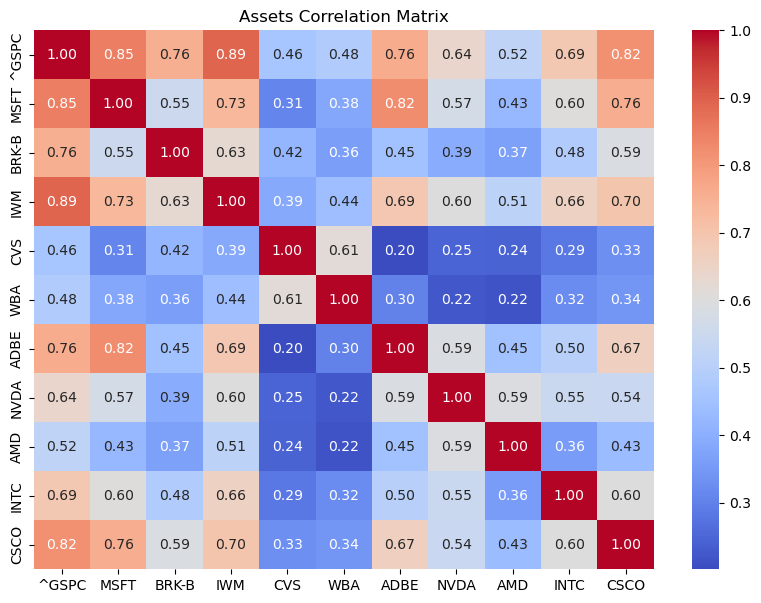

In [10]:
# Pearson correlation to get the basic idea about the relationship
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_df.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
# plt.savefig('images/chart1', dpi=300)

[('CVS', 'INTC'), ('ADBE', 'AMD')]


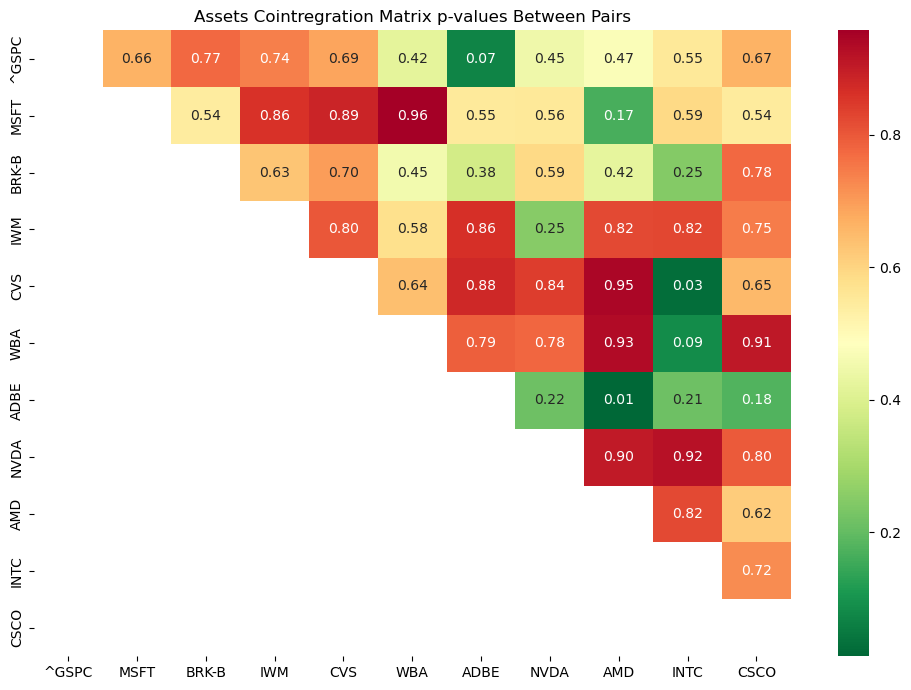

In [4]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_df)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_df.columns,
                yticklabels = train_df.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
plt.tight_layout()
# plt.savefig('images/chart2', dpi=300)


In [5]:
# Performing the stationarity test on the pairs Adobe and AMD.
# Calculate the ratio
spread = train_df['ADBE'] - train_df['AMD']
# ratio = train_df['ADBE']/train_df['AMD']
# Perform Dickey-Fuller test
result = adfuller(spread, maxlag=1)  # Auto-lag determines the lag length based on information criterion

# Output results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpreting the results
if result[1] < 0.05:
    print("The spread series is stationary.")
else:
    print("The spread series is not stationary.")

ADF Statistic: -3.213990
p-value: 0.019189
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
The spread series is stationary.


In [8]:
# Performing the stationarity test on the pairs CVS and Intel.
# Calculate the ratio
# spread = train_df['INTC'] - train_df['CVS']
ratio = train_df['CVS']/train_df['INTC']
# Perform Dickey-Fuller test
result = adfuller(ratio, maxlag=1)  # Auto-lag determines the lag length based on information criterion

# Output results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpreting the results
if result[1] < 0.05:
    print("The spread series is stationary.")
else:
    print("The spread series is not stationary.")

ADF Statistic: -0.471413
p-value: 0.897475
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
The spread series is not stationary.


In [6]:
df_new = df.drop(columns=['^GSPC', 'MSFT', 'BRK-B', 'IWM', 'CVS', 'WBA', 'NVDA', 'INTC', 'CSCO'])
# df_new.to_csv('C:/Users/adi22/Downloads/adobe_amd_pairs.csv')

In [12]:
# train_df, test_df = train_test_split(df_new, test_size=0.8, shuffle=False)
df_adbe = df_new.drop(columns=['AMD'])
df_amd = df_new.drop(columns=['ADBE'])
df_adbe

,ADBE
2018-04-02,212.279999
2018-04-03,215.929993
2018-04-04,225.050003
2018-04-05,223.539993
2018-04-06,218.610001
...,...
2023-04-14,379.380005
2023-04-17,377.920013
2023-04-18,377.549988
2023-04-19,380.109985


Text(0.5, 1.0, 'Spread between Adobe and AMD')

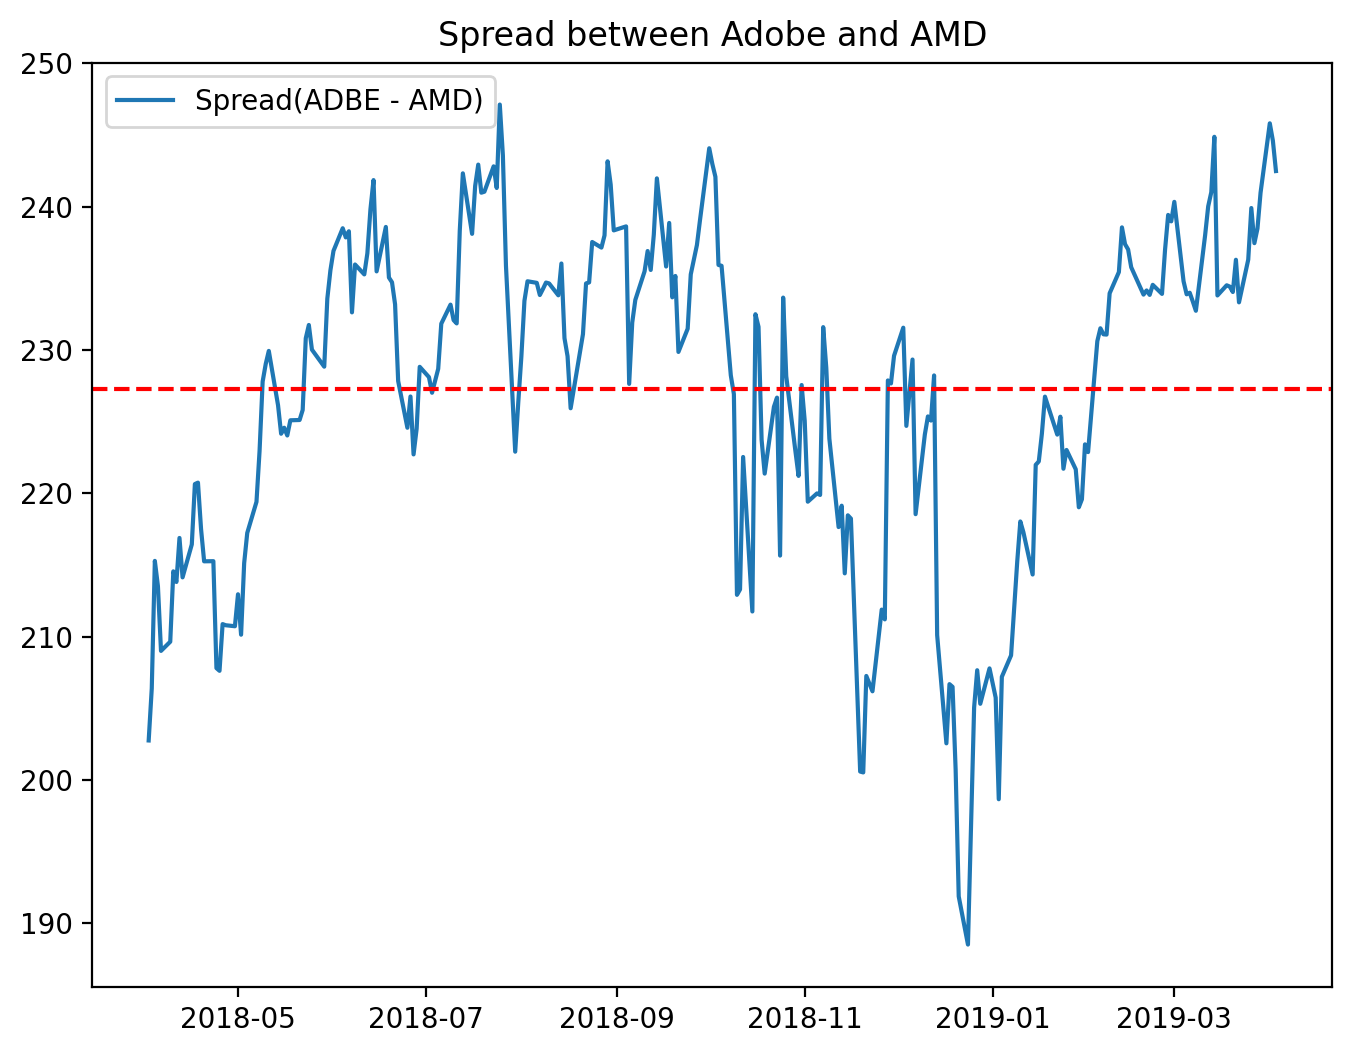

In [9]:
# Plotting the spread between Adobe and AMD
from matplotlib.pyplot import figure
figure(figsize=(8,6), dpi=200)
plt.plot(spread, label = "Spread(ADBE - AMD)")
plt.axhline(spread.mean(), color="red", linestyle='dashed')
plt.legend()
plt.title("Spread between Adobe and AMD")

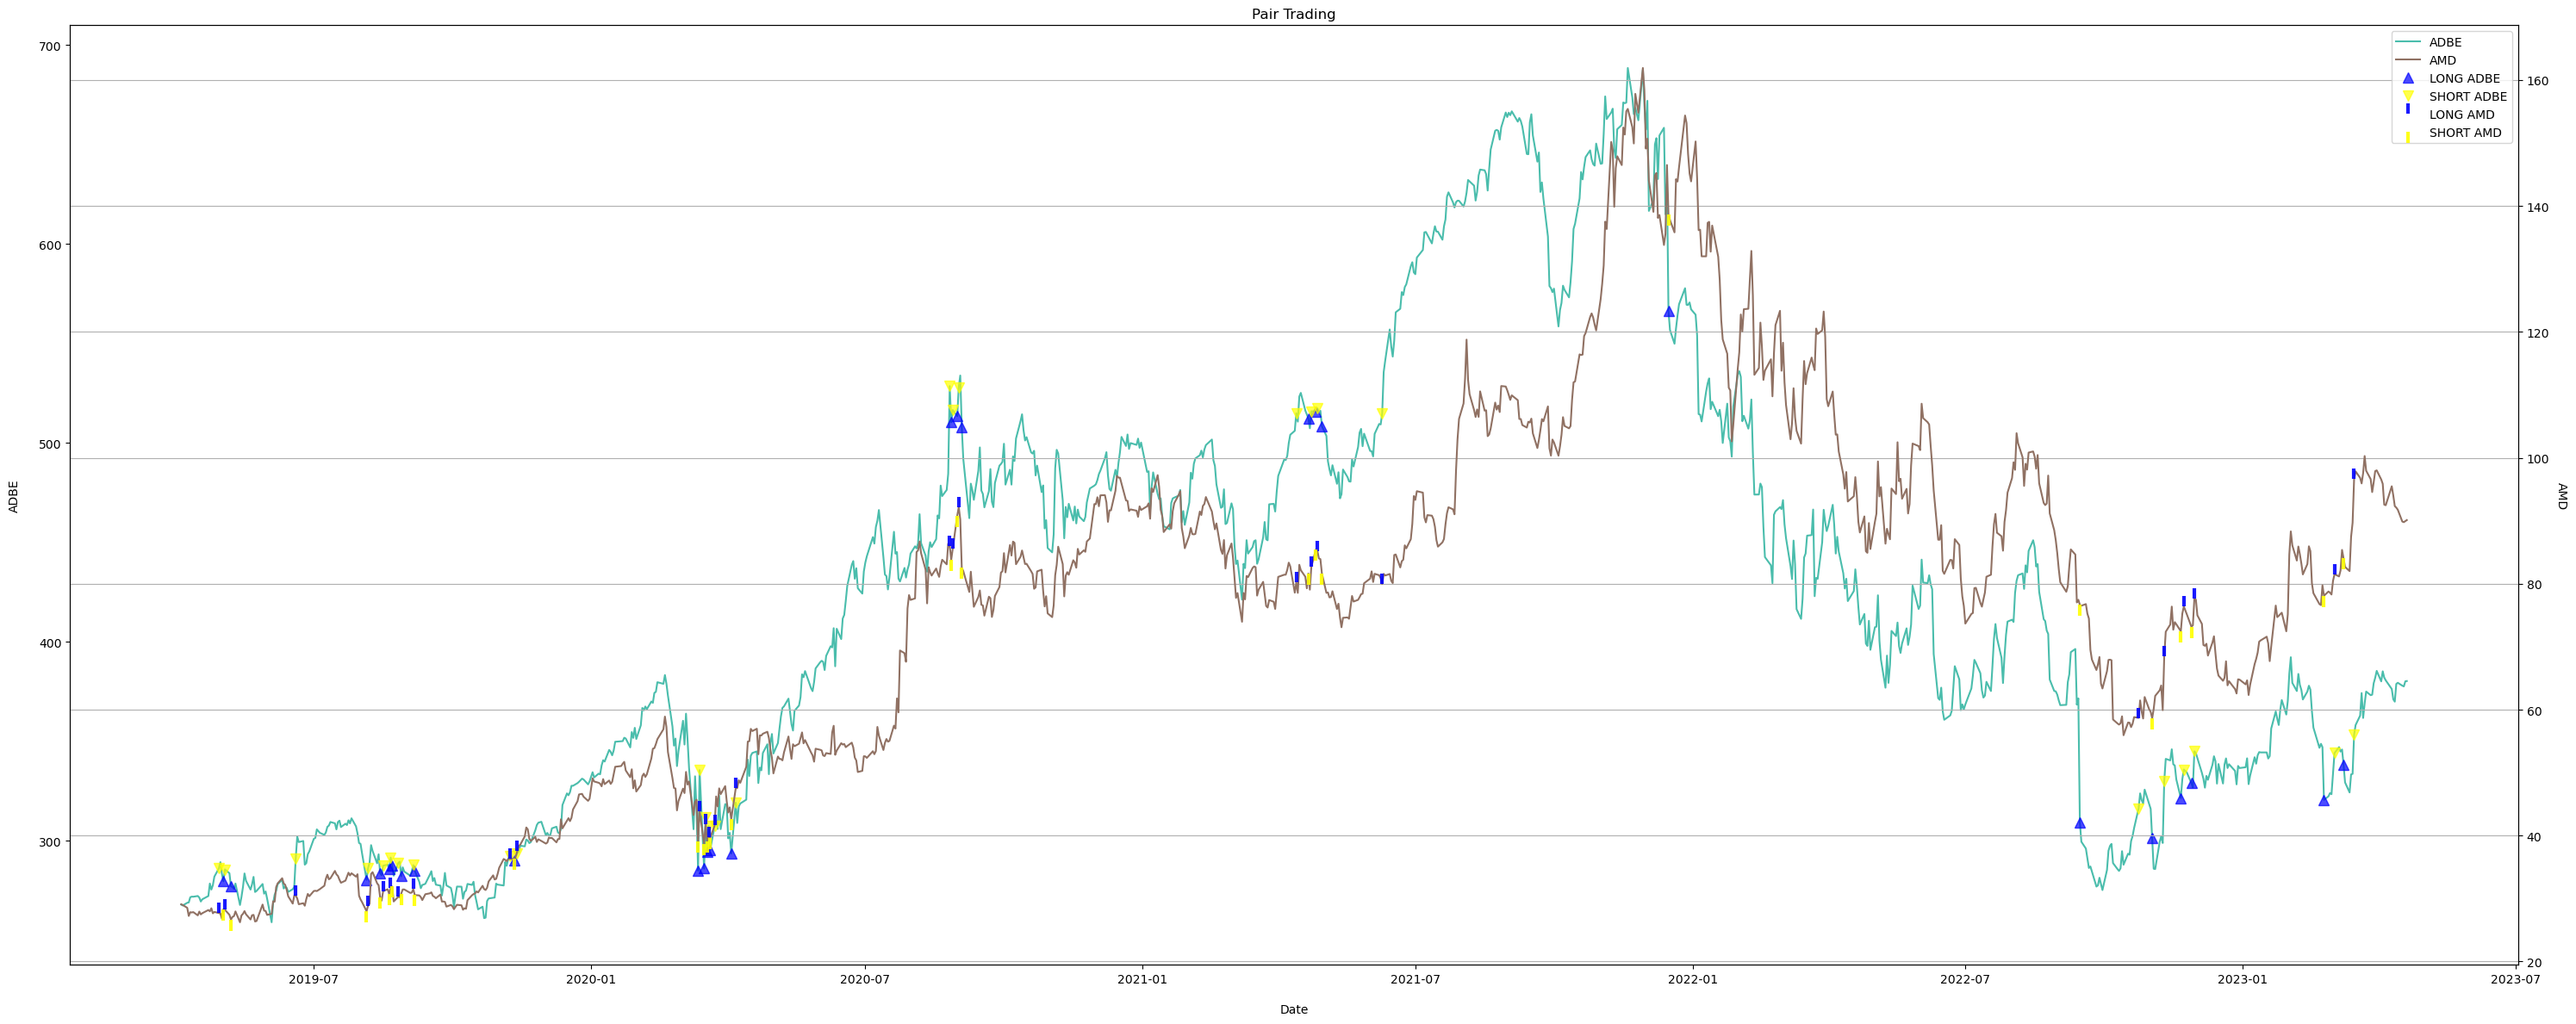

In [15]:
# Defining the 2 assets picked

asset1 = 'ADBE'
asset2 = 'AMD'

# calculate z-score
def zscore(series):
 return (series - series.mean()) / np.std(series)

# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_df[asset1] 
signals['asset2'] = test_df[asset2]
spread = signals.asset1 - signals.asset2

# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(spread)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

# visualize trading signals and position
fig=plt.figure(figsize=(30,12))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')
u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='blue',alpha=0.7)
d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='yellow',alpha=0.7)
u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='blue',alpha=0.9, markeredgewidth=3)
d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='yellow',alpha=0.9,markeredgewidth=3)
bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15
plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')
plt.title('Pair Trading')
plt.xlabel('Date')
plt.grid(True)

plt.tight_layout()

In [18]:
# Calculate Returns for Each Asset
signals['returns1'] = signals['asset1'].pct_change()
signals['returns2'] = signals['asset2'].pct_change()

# Merge Signals with Price Data
signals_with_prices = pd.concat([signals, test_df[[asset1, asset2]]], axis=1)

# Calculate Returns at Buying or Selling Points
signals_with_prices['returns_at_signal1'] = signals_with_prices['returns1'] * signals_with_prices['positions1'].shift(1)
signals_with_prices['returns_at_signal2'] = signals_with_prices['returns2'] * signals_with_prices['positions2'].shift(1)

# Print Returns at Buying or Selling Points
print("Returns at signal points for {}: \n{}".format(asset1, signals_with_prices['returns_at_signal1'][signals_with_prices['positions1'] != 0]))
print("Returns at signal points for {}: \n{}".format(asset2, signals_with_prices['returns_at_signal2'][signals_with_prices['positions2'] != 0]))


Returns at signal points for ADBE: 
2019-04-04         NaN
2019-04-29    0.000000
2019-05-02   -0.000000
2019-05-03    0.021241
2019-05-07   -0.000000
2019-06-19    0.000000
2019-08-05   -0.000000
2019-08-06    0.020866
2019-08-14   -0.000000
2019-08-16    0.000000
2019-08-20   -0.000000
2019-08-21    0.020370
2019-08-22    0.013172
2019-08-26    0.000000
2019-08-28   -0.000000
2019-09-05    0.000000
2019-09-06    0.009765
2019-11-08    0.000000
2019-11-11    0.007488
2019-11-13    0.000000
2020-03-12   -0.000000
2020-03-13    0.177193
2020-03-16    0.147452
2020-03-17    0.090130
2020-03-18    0.055162
2020-03-19    0.043787
2020-03-20    0.039576
2020-03-23    0.040394
2020-04-03   -0.000000
2020-04-06    0.086918
2020-08-26    0.000000
2020-08-27    0.034381
2020-08-28    0.011992
2020-08-31    0.005906
2020-09-01    0.028361
2020-09-03   -0.000000
2021-04-13    0.000000
2021-04-21   -0.000000
2021-04-23    0.000000
2021-04-26    0.000271
2021-04-27    0.003141
2021-04-30   -0.00000

In [16]:
# Number of signals generated

num_signals_asset1 = signals['positions1'].abs().sum()
num_signals_asset2 = signals['positions2'].abs().sum()
total_signals = num_signals_asset1 + num_signals_asset2

print("Number of signals generated for", asset1, ":", num_signals_asset1)
print("Number of signals generated for", asset2, ":", num_signals_asset2)
print("Total number of signals generated:", total_signals)


Number of signals generated for ADBE : 55.0
Number of signals generated for AMD : 55.0
Total number of signals generated: 110.0


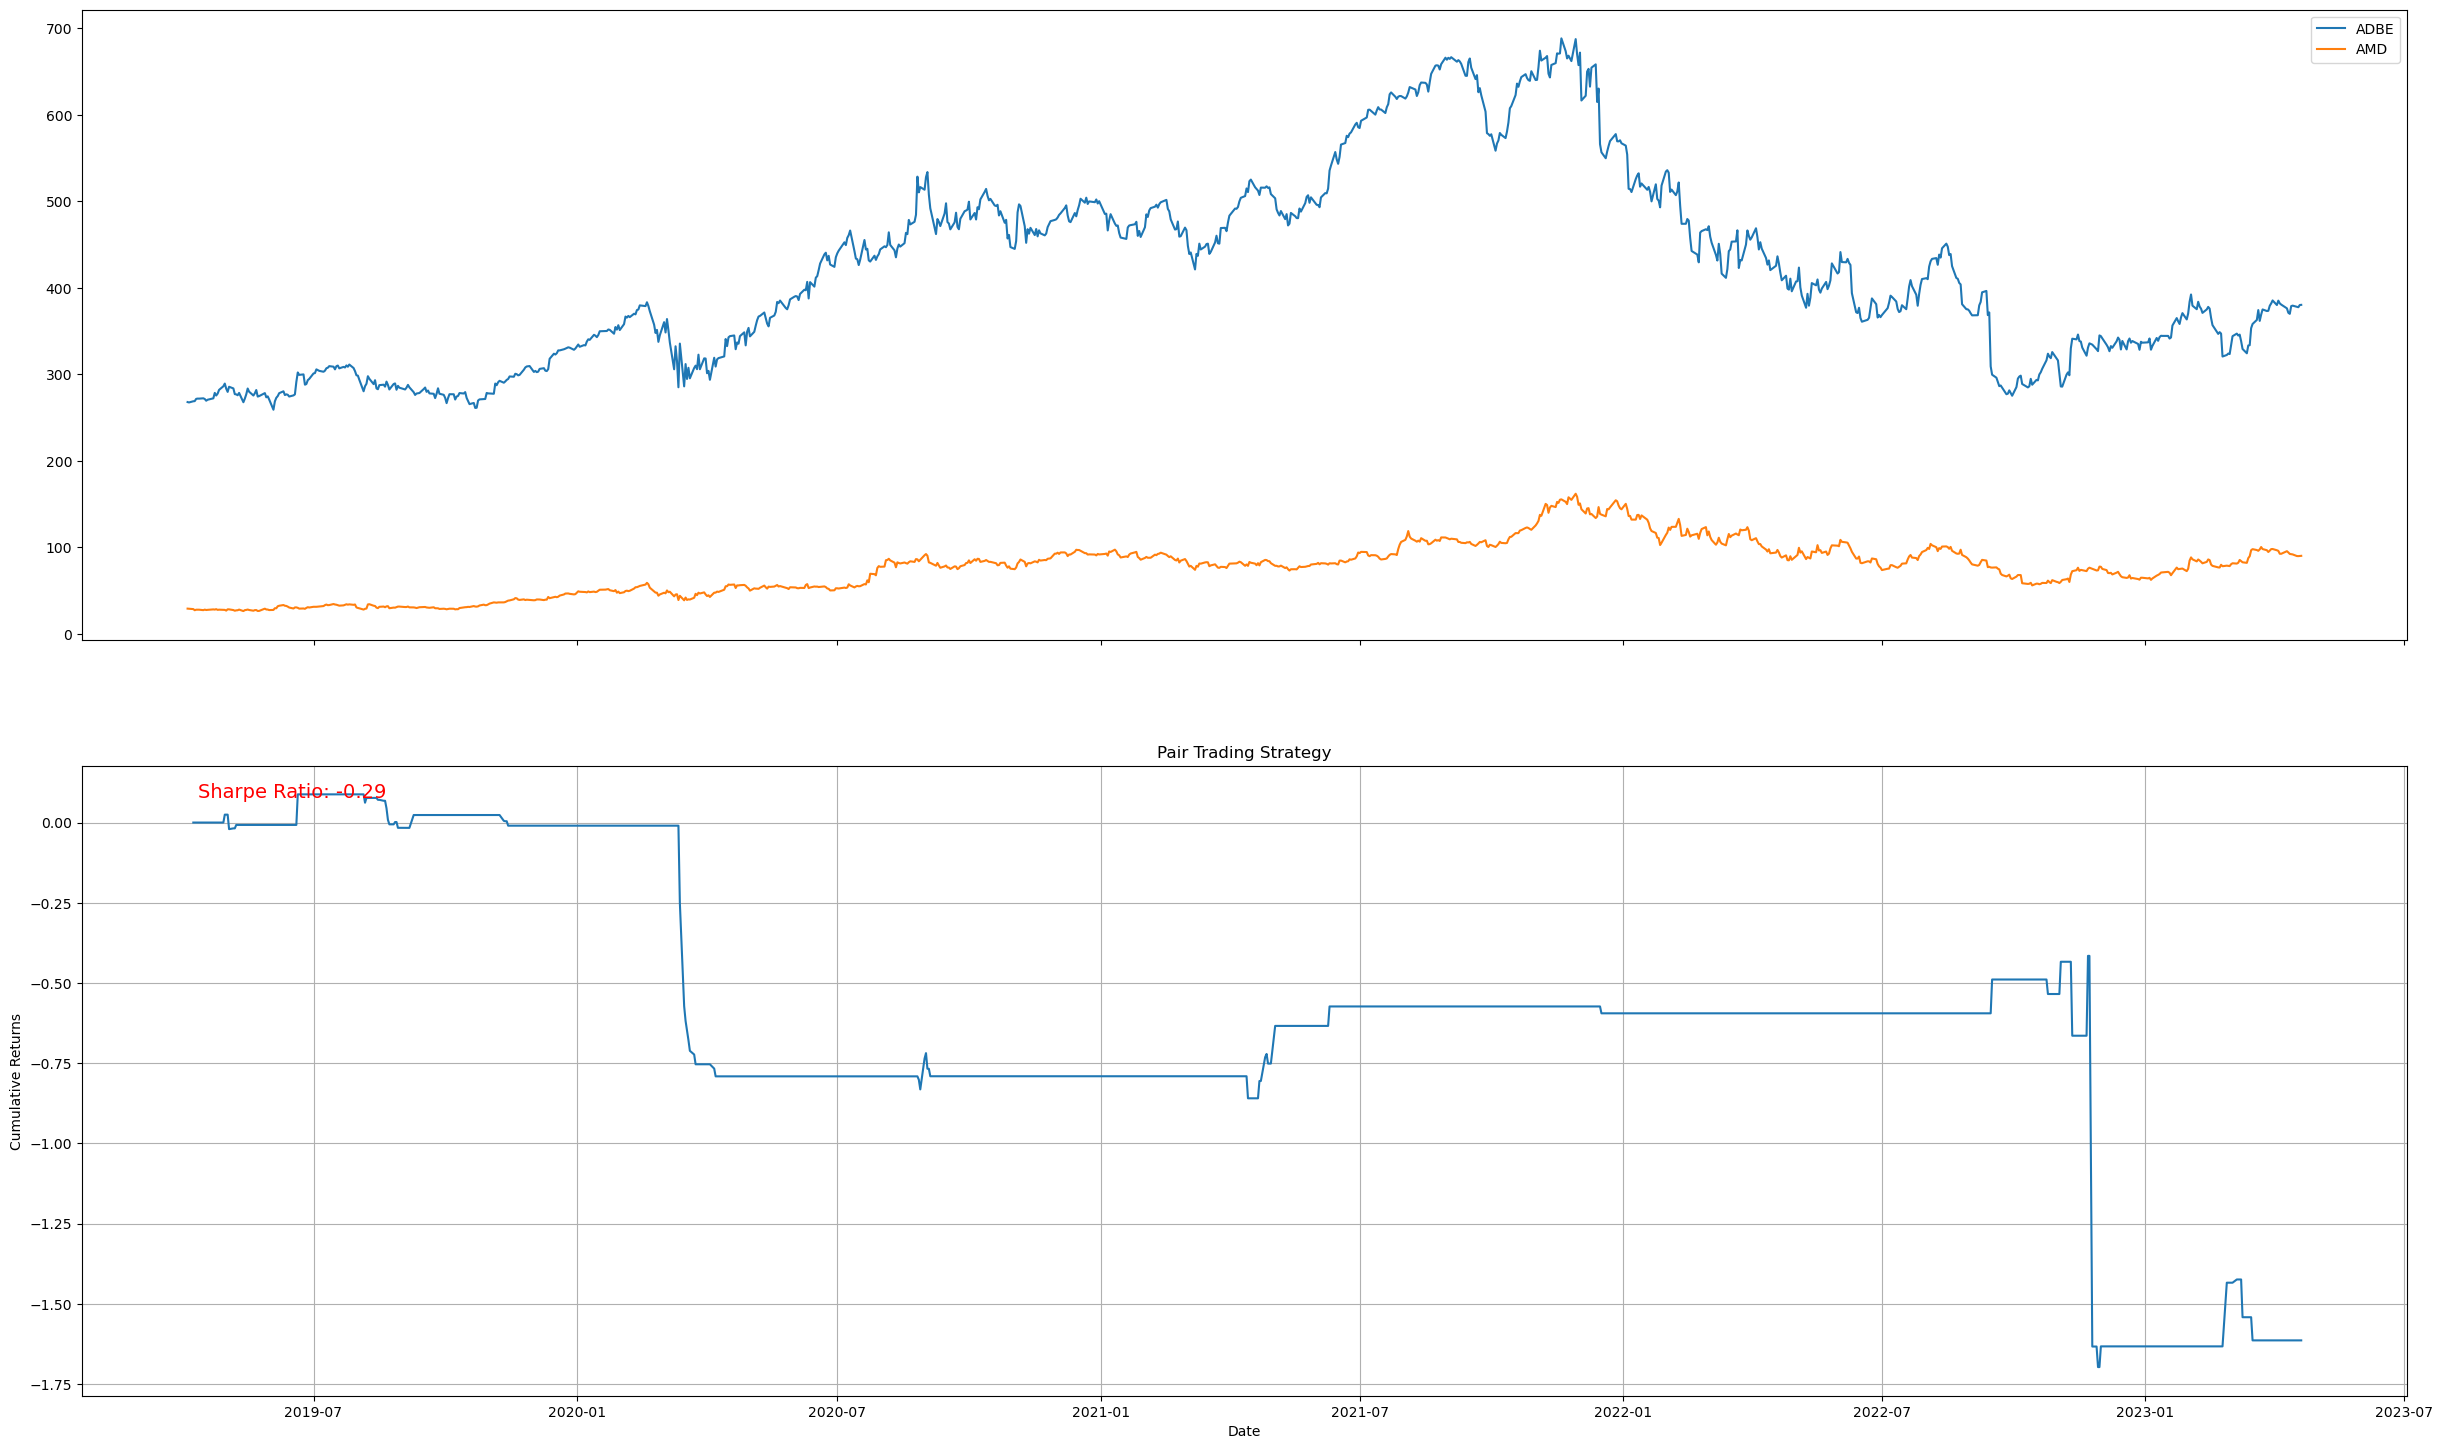

In [17]:
# Normalize asset prices
signals['asset1_normalized'] = (signals['asset1'] - signals['asset1'].mean()) / signals['asset1'].std()
signals['asset2_normalized'] = (signals['asset2'] - signals['asset2'].mean()) / signals['asset2'].std()

# Calculate daily returns for each asset
signals['asset1_returns'] = signals['asset1_normalized'].pct_change()
signals['asset2_returns'] = signals['asset2_normalized'].pct_change()

# Calculate portfolio returns based on positions
signals['portfolio_returns'] = signals['positions1'].shift(1) * signals['asset1_returns'] + signals['positions2'].shift(1) * signals['asset2_returns']

# Calculate cumulative returns
signals['cumulative_returns'] = (1 + signals['portfolio_returns']).cumprod() - 1

# Calculate Sharpe ratio
daily_returns_mean = signals['portfolio_returns'].mean()
daily_returns_std = signals['portfolio_returns'].std()
sharpe_ratio = (252**0.5) * (daily_returns_mean / daily_returns_std)

# Visualize trading signals and position
fig, ax = plt.subplots(2, 1, figsize=(30, 18), sharex=True)

# Plot asset prices
ax[0].plot(signals.index, signals['asset1'], label=asset1)
ax[0].plot(signals.index, signals['asset2'], label=asset2)
ax[0].legend()

# Plot trading signals
ax[1].plot(signals.index, signals['cumulative_returns'])
ax[1].set_ylabel('Cumulative Returns')

# Add Sharpe ratio to the plot
ax[1].annotate(f'Sharpe Ratio: {sharpe_ratio:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=14, color='red')

plt.xlabel('Date')
plt.title('Pair Trading Strategy')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Assuming you have defined your pair trading strategy function or class
def pair_trading_strategy(adbe_df, amd_df, entry_threshold, exit_threshold):
    # Calculate spread between ADBE and AMD
    spread = adbe_df['Close'] - amd_df['Close']
    
    # Calculate z-score of the spread
    def zscore(series):
        return (series - series.mean()) / np.std(series)

    z_score = zscore(spread)

    # Generate signals
    signals = pd.DataFrame()
    signals['z_score'] = z_score
    signals['signals'] = 0
    signals['signals'][signals['z_score'] > entry_threshold] = 1  # Buy ADBE, Sell AMD
    signals['signals'][signals['z_score'] < -entry_threshold] = -1  # Sell ADBE, Buy AMD
    signals['positions'] = signals['signals'].diff()
    
    return signals

# Define a function to calculate Sharpe ratio
def sharpe_ratio(returns):
    return np.mean(returns) / np.std(returns)

# Define a function to calculate strategy returns
def calculate_returns(signals, adbe_df, amd_df):
    adbe_returns = adbe_df['Close'].pct_change().shift(-1)
    amd_returns = amd_df['Close'].pct_change().shift(-1)
    spread_returns = adbe_returns - amd_returns
    strategy_returns = spread_returns * signals['positions'].shift(-1)
    return strategy_returns

# Define a function to calculate Sharpe ratio score
def calculate_sharpe_ratio_score(adbe_df, amd_df, entry_threshold, exit_threshold):
    signals = pair_trading_strategy(adbe_df, amd_df, entry_threshold, exit_threshold)
    returns = calculate_returns(signals, adbe_df, amd_df)
    return sharpe_ratio(returns.dropna())

# Define a range of threshold values to search
threshold_range = [0.5, 1.0, 1.5, 2.0]  # Adjust as needed

# Create a scorer based on the Sharpe ratio
scorer = make_scorer(calculate_sharpe_ratio_score, greater_is_better=True)

# Define the parameter grid for grid search
param_grid = {'entry_threshold': threshold_range, 'exit_threshold': threshold_range}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=None, param_grid=param_grid, scoring=scorer, cv=5)

# Fit the grid search to your data
grid_search.fit(adbe_df, amd_df)  # adbe_df and amd_df are your dataframes

# Get the best threshold values
best_entry_threshold = grid_search.best_params_['entry_threshold']
best_exit_threshold = grid_search.best_params_['exit_threshold']

print("Best entry threshold:", best_entry_threshold)
print("Best exit threshold:", best_exit_threshold)



# here you used an example of a threshold of 1 and 0.5. is there a way to use hyperparameter tuning to optimize the best threshold out of a list of thresholds?

# Instead of just asking it to optimize threshold, also ask it to optimize long cap, short cap, and holding period


# Predicting future stock prices

In [15]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [28]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:pd.Timestamp(target_date)].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['ADBE'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

In [29]:
# Predicting Adobe stock prices

windowed_df_adbe = df_to_windowed_df(df_adbe, '2018-04-02', '2023-04-20', 5)
windowed_df_adbe

TypeError: Cannot compare Timestamp with datetime.date. Use ts == pd.Timestamp(date) or ts.date() == date instead.

In [121]:
import pandas as pd

def create_windowed_df(dataframe, n):
    # Create an empty DataFrame to store the windowed data
    windowed_df = pd.DataFrame(index=dataframe.index, columns=['Target Date', 'Target'] + [f'X{i}' for i in range(1, n+1)])
    
    # Loop through each row in the DataFrame
    for i in range(n, len(dataframe)):
        # Extract the target date and its corresponding closing price
        target_date = dataframe.index[i]
        target_close = dataframe.iloc[i]['ADBE']
        
        # Extract the previous n closing prices
        window_close = dataframe.iloc[i-n:i]['ADBE'].values
        
        # Assign values to the windowed DataFrame
        windowed_df.at[target_date, 'Target Date'] = target_date
        
        for j in range(n):
            windowed_df.at[target_date, f'X{j+1}'] = window_close[j]
        
        windowed_df.at[target_date, 'Target'] = target_close
    
    return windowed_df.dropna()  # Drop rows with any NaN values

# Call the function to create the windowed DataFrame
windowed_df_adbe = create_windowed_df(df_adbe, n=5)

# Display the resulting DataFrame
print(windowed_df_adbe)


           Target Date      Target          X1          X2          X3  \
2018-04-09  2018-04-09  219.169998  212.279999  215.929993  225.050003   
2018-04-10  2018-04-10  224.529999  215.929993  225.050003  223.539993   
2018-04-11  2018-04-11  223.630005  225.050003  223.539993  218.610001   
2018-04-12  2018-04-12  226.960007  223.539993  218.610001  219.169998   
2018-04-13  2018-04-13  224.059998  218.610001  219.169998  224.529999   
...                ...         ...         ...         ...         ...   
2023-04-14  2023-04-14  379.380005  380.600006      376.25  371.109985   
2023-04-17  2023-04-17  377.920013      376.25  371.109985  369.890015   
2023-04-18  2023-04-18  377.549988  371.109985  369.890015  378.799988   
2023-04-19  2023-04-19  380.109985  369.890015  378.799988  379.380005   
2023-04-20  2023-04-20   380.26001  378.799988  379.380005  377.920013   

                    X4          X5  
2018-04-09  223.539993  218.610001  
2018-04-10  218.610001  219.169998  


In [122]:
def move_to_end(dataframe):
    columns = dataframe.columns.tolist()
    target_index = columns.index('Target')
    new_columns = columns[:target_index] + columns[target_index+1:] + [columns[target_index]]
    return dataframe[new_columns]

windowed_df_adbe = move_to_end(windowed_df_adbe)
print(windowed_df_adbe)


           Target Date          X1          X2          X3          X4  \
2018-04-09  2018-04-09  212.279999  215.929993  225.050003  223.539993   
2018-04-10  2018-04-10  215.929993  225.050003  223.539993  218.610001   
2018-04-11  2018-04-11  225.050003  223.539993  218.610001  219.169998   
2018-04-12  2018-04-12  223.539993  218.610001  219.169998  224.529999   
2018-04-13  2018-04-13  218.610001  219.169998  224.529999  223.630005   
...                ...         ...         ...         ...         ...   
2023-04-14  2023-04-14  380.600006      376.25  371.109985  369.890015   
2023-04-17  2023-04-17      376.25  371.109985  369.890015  378.799988   
2023-04-18  2023-04-18  371.109985  369.890015  378.799988  379.380005   
2023-04-19  2023-04-19  369.890015  378.799988  379.380005  377.920013   
2023-04-20  2023-04-20  378.799988  379.380005  377.920013  377.549988   

                    X5      Target  
2018-04-09  218.610001  219.169998  
2018-04-10  219.169998  224.529999  


In [123]:
import numpy as np

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df_adbe)

dates.shape, X.shape, y.shape

((1268,), (1268, 5, 1), (1268,))

In [124]:
# Splitting the data into training, validation and testing sets using 80% for training, 10% for validation, and 10% for testing
split_train = int(len(dates) * .8)
split_val = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:split_train], X[:split_train], y[:split_train]

dates_val, X_val, y_val = dates[split_train:split_val], X[split_train:split_val], y[split_train:split_val]
dates_test, X_test, y_test = dates[split_val:], X[split_val:], y[split_val:]

# plt.plot(dates_train, y_train)
# plt.plot(dates_val, y_val)
# plt.plot(dates_test, y_test)

# plt.legend(['Train', 'Validation', 'Test'])

In [84]:
pip install tensorflow

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 167154.8125 - mean_absolute_error: 387.1060 - val_loss: 142441.7031 - val_mean_absolute_error: 374.3637
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 168844.2188 - mean_absolute_error: 388.4031 - val_loss: 132522.6094 - val_mean_absolute_error: 360.8626
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 152117.8594 - mean_absolute_error: 367.3736 - val_loss: 106713.7109 - val_mean_absolute_error: 323.1343
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 116710.5703 - mean_absolute_error: 315.9825 - val_loss: 65458.0352 - val_mean_absolute_error: 251.3279
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 76111.5625 - mean_absolute_error: 240.8607 - val_loss: 24185.8730 - val_mean_absolute_error: 147.9438
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34734.6016 - mean_absolute_error: 137.9158 - val_loss: 4215.7725 - val_mean_absolute_error: 60.9000
Epoch 7/100
32/32 ━━━━━━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 127.4069 - mean_absolute_error: 8.3266 - val_loss: 282.1150 - val_mean_absolute_error: 12.9173
Epoch 45/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 101.6946 - mean_absolute_error: 7.0877 - val_loss: 226.6715 - val_mean_absolute_error: 11.4241
Epoch 46/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121.6768 - mean_absolute_error: 8.3171 - val_loss: 153.0046 - val_mean_absolute_error: 8.9309
Epoch 47/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 113.3414 - mean_absolute_error: 7.4098 - val_loss: 144.0488 - val_mean_absolute_error: 8.6213
Epoch 48/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 96.9205 - mean_absolute_error: 6.8474 - val_loss: 138.5665 - val_mean_absolute_error: 8.5137
Epoch 49/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 107.2641 - mean_absolute_error: 7.1123 - val_loss: 131.7425 - val_mean_absolute_error: 8.3963
Epoch 50/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 98.7957 - mean_absolute_erro

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 94.1869 - mean_absolute_error: 7.0466 - val_loss: 164.4742 - val_mean_absolute_error: 9.3468
Epoch 88/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 86.0023 - mean_absolute_error: 6.4956 - val_loss: 134.3656 - val_mean_absolute_error: 8.4549
Epoch 89/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 79.8443 - mean_absolute_error: 6.2427 - val_loss: 133.8359 - val_mean_absolute_error: 8.3944
Epoch 90/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 92.9498 - mean_absolute_error: 6.7588 - val_loss: 266.4451 - val_mean_absolute_error: 12.4682
Epoch 91/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 107.5883 - mean_absolute_error: 7.7358 - val_loss: 197.6965 - val_mean_absolute_error: 10.3661
Epoch 92/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 108.4094 - mean_absolute_error: 7.5948 - val_loss: 167.2690 - val_mean_absolute_error: 9.4105
Epoch 93/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 100.6344 - mean_absolute_error:

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


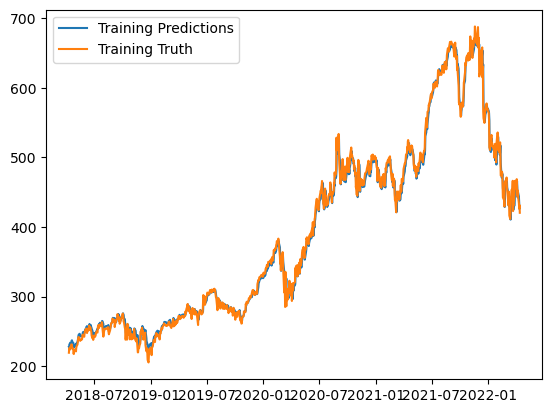

In [126]:
train_pred = model.predict(X_train).flatten()

plt.plot(dates_train, train_pred)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Truth'])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


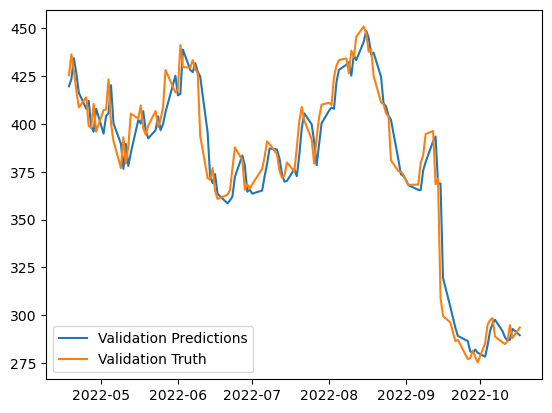

In [127]:
val_pred = model.predict(X_val).flatten()

plt.plot(dates_val, val_pred)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Truth'])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


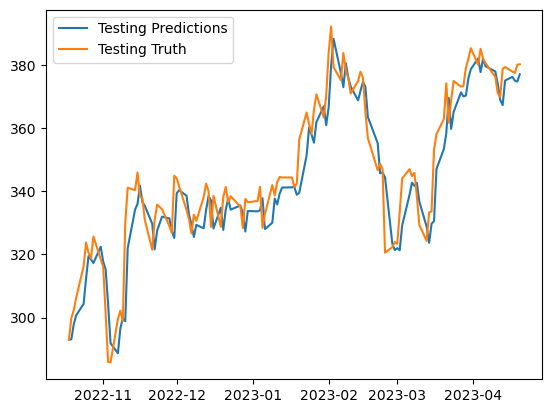

In [128]:
test_pred = model.predict(X_test).flatten()

plt.plot(dates_test, test_pred)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Truth'])

In [ ]:
# As you can see, the model performs really well on the test set and the stock prediction is almost identical, or at least
# the flow of it is probably the same.

In [130]:
X_test[-1]

array([[378.8 ],
       [379.38],
       [377.92],
       [377.55],
       [380.11]], dtype=float32)

In [119]:
# Predicting Spread20 values after April 21st, 2023 up until today.

future_dates_adbe = pd.date_range(start='2023-04-22', end='2024-05-15', freq='B')

future_predictions_adbe = []

# Use the last window of data from test data as initial input
last_window_adbe = X_test[-1]

# Iterate over future dates
for date in future_dates_adbe:
    # Predict using the current last_window
    future_pred_adbe = model.predict(np.array([last_window_adbe])).flatten()
    
    # Append the prediction to the list of future predictions
    future_predictions_adbe.append(future_pred_adbe)
    
    # Update last_window by shifting the values and replacing the last element with the predicted value
    last_window_adbe[:-1] = last_window_adbe[1:]
    last_window_adbe[-1] = future_pred_adbe

# Convert future_predictions to a numpy array
future_predictions_adbe = np.array(future_predictions_adbe)
future_predictions_adbe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

array([[217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],
       [217.09457],


# Predicting future positions

In [ ]:
# Now that we know our model works well, we could build a similar model for predicting the future positions, based on our
# pairs trading strategy that we did on excel, using the 20 day z score difference and the trailing 60 day volatility

In [ ]:
# Creating dataframe with the calculated future positions

In [105]:
df_spread = pd.read_csv(r"C:\Users\adi22\OneDrive\spread.csv")
df_spread

,Date,Spread
0,7/25/2018,1.573844
1,7/26/2018,0.187718
2,7/27/2018,-0.790273
3,7/30/2018,-2.790317
4,7/31/2018,-1.745787
...,...,...
1188,4/14/2023,1.201391
1189,4/17/2023,1.288710
1190,4/18/2023,1.043676
1191,4/19/2023,0.694293


In [106]:
import pandas as pd

def create_windowed_df_spread(dataframe, n):
    # Create an empty DataFrame to store the windowed data
    windowed_df = pd.DataFrame(index=dataframe.index, columns=['Target Date', 'Target'] + [f'X{i}' for i in range(1, n+1)])
    
    # Loop through each row in the DataFrame
    for i in range(n, len(dataframe)):
        # Extract the target date and its corresponding closing price
        target_date = dataframe.Date[i]
        target_close = dataframe.iloc[i]['Spread']
        
        # Extract the previous n closing prices
        window_close = dataframe.iloc[i-n:i]['Spread'].values
        
        # Assign values to the windowed DataFrame
        windowed_df.at[target_date, 'Target Date'] = target_date
        
        for j in range(n):
            windowed_df.at[target_date, f'X{j+1}'] = window_close[j]
        
        windowed_df.at[target_date, 'Target'] = target_close
    
    return windowed_df.dropna()  # Drop rows with any NaN values


In [107]:
windowed_df_spread = create_windowed_df_spread(df_spread, n=5)
windowed_df_spread

,Target Date,Target,X1,X2,X3,X4,X5
8/1/2018,8/1/2018,-1.542425,1.573844,0.187718,-0.790273,-2.790317,-1.745787
8/2/2018,8/2/2018,-1.18941,0.187718,-0.790273,-2.790317,-1.745787,-1.542425
8/3/2018,8/3/2018,-0.72242,-0.790273,-2.790317,-1.745787,-1.542425,-1.18941
8/6/2018,8/6/2018,-1.141473,-2.790317,-1.745787,-1.542425,-1.18941,-0.72242
8/7/2018,8/7/2018,-1.211976,-1.745787,-1.542425,-1.18941,-0.72242,-1.141473
...,...,...,...,...,...,...,...
4/14/2023,4/14/2023,1.201391,0.402481,0.073426,0.130195,0.587471,1.10989
4/17/2023,4/17/2023,1.28871,0.073426,0.130195,0.587471,1.10989,1.201391
4/18/2023,4/18/2023,1.043676,0.130195,0.587471,1.10989,1.201391,1.28871
4/19/2023,4/19/2023,0.694293,0.587471,1.10989,1.201391,1.28871,1.043676


In [108]:
windowed_df_spread = move_to_end(windowed_df_spread)
windowed_df_spread

,Target Date,X1,X2,X3,X4,X5,Target
8/1/2018,8/1/2018,1.573844,0.187718,-0.790273,-2.790317,-1.745787,-1.542425
8/2/2018,8/2/2018,0.187718,-0.790273,-2.790317,-1.745787,-1.542425,-1.18941
8/3/2018,8/3/2018,-0.790273,-2.790317,-1.745787,-1.542425,-1.18941,-0.72242
8/6/2018,8/6/2018,-2.790317,-1.745787,-1.542425,-1.18941,-0.72242,-1.141473
8/7/2018,8/7/2018,-1.745787,-1.542425,-1.18941,-0.72242,-1.141473,-1.211976
...,...,...,...,...,...,...,...
4/14/2023,4/14/2023,0.402481,0.073426,0.130195,0.587471,1.10989,1.201391
4/17/2023,4/17/2023,0.073426,0.130195,0.587471,1.10989,1.201391,1.28871
4/18/2023,4/18/2023,0.130195,0.587471,1.10989,1.201391,1.28871,1.043676
4/19/2023,4/19/2023,0.587471,1.10989,1.201391,1.28871,1.043676,0.694293


In [109]:
dates, X, y = windowed_df_to_date_X_y(windowed_df_spread)

dates.shape, X.shape, y.shape

((1188,), (1188, 5, 1), (1188,))

In [110]:
# Splitting the data into training, validation and testing sets using 80% for training, 10% for validation, and 10% for testing
split_train = int(len(dates) * .8)
split_val = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:split_train], X[:split_train], y[:split_train]

dates_val, X_val, y_val = dates[split_train:split_val], X[split_train:split_val], y[split_train:split_val]
dates_test, X_test, y_test = dates[split_val:], X[split_val:], y[split_val:]

In [111]:
model_spread = Sequential([layers.Input((5, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model_spread.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model_spread.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1.4344 - mean_absolute_error: 0.9179 - val_loss: 0.1925 - val_mean_absolute_error: 0.3552
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5431 - mean_absolute_error: 0.5496 - val_loss: 0.1541 - val_mean_absolute_error: 0.3153
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4099 - mean_absolute_error: 0.4842 - val_loss: 0.1241 - val_mean_absolute_error: 0.2777
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3418 - mean_absolute_error: 0.4424 - val_loss: 0.1148 - val_mean_absolute_error: 0.2645
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3231 - mean_absolute_error: 0.4296 - val_loss: 0.1121 - val_mean_absolute_error: 0.2547
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3238 - mean_absolute_error: 0.4301 - val_loss: 0.1064 - val_mean_absolute_error: 0.2469
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3033 - mean_absolute_error: 0.4161 - val

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3091 - mean_absolute_error: 0.4116 - val_loss: 0.1028 - val_mean_absolute_error: 0.2349
Epoch 46/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2958 - mean_absolute_error: 0.3922 - val_loss: 0.1021 - val_mean_absolute_error: 0.2335
Epoch 47/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2951 - mean_absolute_error: 0.3903 - val_loss: 0.1038 - val_mean_absolute_error: 0.2326
Epoch 48/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3015 - mean_absolute_error: 0.4010 - val_loss: 0.1056 - val_mean_absolute_error: 0.2398
Epoch 49/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2873 - mean_absolute_error: 0.3938 - val_loss: 0.1077 - val_mean_absolute_error: 0.2401
Epoch 50/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2897 - mean_absolute_error: 0.3919 - val_loss: 0.1159 - val_mean_absolute_error: 0.2540
Epoch 51/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2740 - mean_absolute_error: 0.3997 - val_loss: 0.

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2668 - mean_absolute_error: 0.3922 - val_loss: 0.1124 - val_mean_absolute_error: 0.2481
Epoch 90/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2721 - mean_absolute_error: 0.3878 - val_loss: 0.1094 - val_mean_absolute_error: 0.2451
Epoch 91/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2677 - mean_absolute_error: 0.3838 - val_loss: 0.1076 - val_mean_absolute_error: 0.2422
Epoch 92/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2524 - mean_absolute_error: 0.3758 - val_loss: 0.1062 - val_mean_absolute_error: 0.2402
Epoch 93/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2734 - mean_absolute_error: 0.3940 - val_loss: 0.1055 - val_mean_absolute_error: 0.2383
Epoch 94/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2268 - mean_absolute_error: 0.3590 - val_loss: 0.1107 - val_mean_absolute_error: 0.2458
Epoch 95/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2722 - mean_absolute_error: 0.3894 - val_loss: 0

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


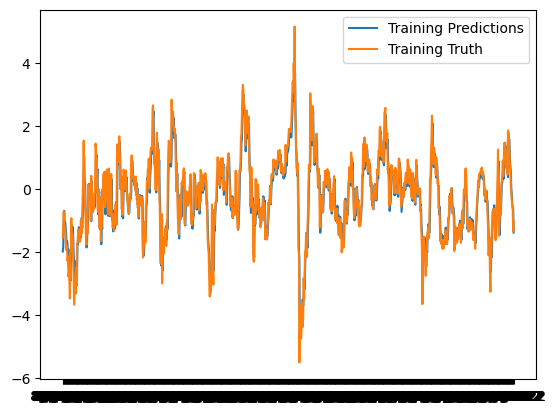

In [113]:
train_pred = model_spread.predict(X_train).flatten()

plt.plot(dates_train, train_pred)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Truth'])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


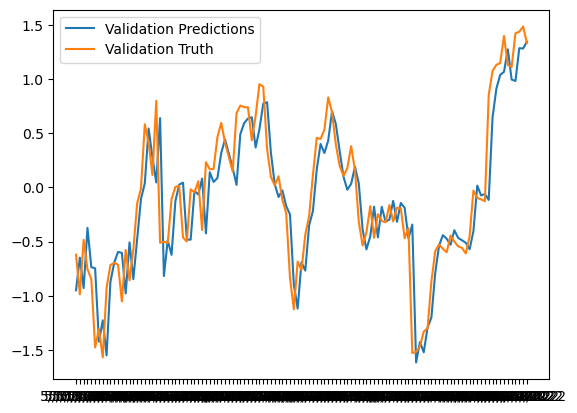

In [114]:
val_pred = model_spread.predict(X_val).flatten()

plt.plot(dates_val, val_pred)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Truth'])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


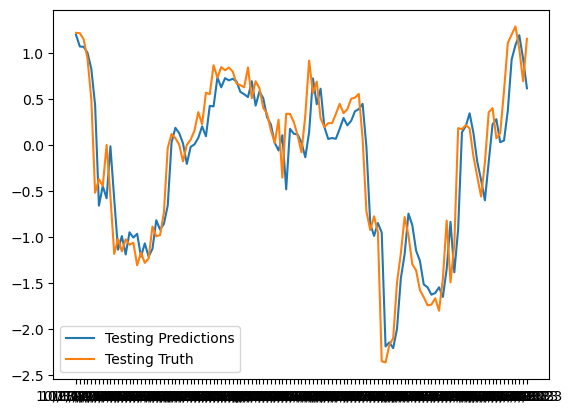

In [115]:
test_pred = model_spread.predict(X_test).flatten()

plt.plot(dates_test, test_pred)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Truth'])

In [116]:
# Predicting Spread20 values after April 21st, 2023 up until today.

future_predictions = []

# Use the last window of data from test data as initial input
last_window = X_test[-1]

# Iterate over future dates
for date in future_dates:
    # Predict using the current last_window
    future_pred = model.predict(np.array([last_window])).flatten()
    
    # Append the prediction to the list of future predictions
    future_predictions.append(future_pred)
    
    # Update last_window by shifting the values and replacing the last element with the predicted value
    last_window[:-1] = last_window[1:]
    last_window[-1] = future_pred

# Convert future_predictions to a numpy array
future_predictions = np.array(future_predictions)


array([[1.1098896],
       [1.2013906],
       [1.2887096],
       [1.043676 ],
       [0.6942933]], dtype=float32)

# Extras

In [14]:
import datetime 

# sp500_data.reset_index(inplace=True)
# sp500_data.columns
# sp500_data['Date'] = sp500_data['Date'].astype('datetime64')
sp500_data['Date'] = pd.to_datetime(sp500_data['Date']).dt.normalize()

print(sp500_data)


                          Date         Open         High          Low  \
0    2000-01-03 00:00:00-05:00  1469.250000  1478.000000  1438.359985   
1    2000-01-04 00:00:00-05:00  1455.219971  1455.219971  1397.430054   
2    2000-01-05 00:00:00-05:00  1399.420044  1413.270020  1377.680054   
3    2000-01-06 00:00:00-05:00  1402.109985  1411.900024  1392.099976   
4    2000-01-07 00:00:00-05:00  1403.449951  1441.469971  1400.729980   
...                        ...          ...          ...          ...   
6108 2024-04-15 00:00:00-04:00  5149.669922  5168.430176  5052.470215   
6109 2024-04-16 00:00:00-04:00  5064.589844  5079.839844  5039.830078   
6110 2024-04-17 00:00:00-04:00  5068.970215  5077.959961  5007.250000   
6111 2024-04-18 00:00:00-04:00  5031.520020  5056.660156  5001.890137   
6112 2024-04-19 00:00:00-04:00  5005.439941  5019.020020  4953.560059   

            Close      Volume  Dividends  Stock Splits  
0     1455.219971   931800000        0.0           0.0  
1     139

In [18]:
sp_df = pd.read_csv(r"C:\Users\adi22\Downloads\SP500_Historical_Data_Cleaned.csv")
rus_df = pd.read_csv(r"C:\Users\adi22\Downloads\RUT.csv")
sp_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0


In [19]:
sp_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
sp_df

,Date,Open,High,Low,Close,Volume
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000
...,...,...,...,...,...,...
6108,2024-04-15,5149.669922,5168.430176,5052.470215,5061.819824,3950210000
6109,2024-04-16,5064.589844,5079.839844,5039.830078,5051.410156,4006200000
6110,2024-04-17,5068.970215,5077.959961,5007.250000,5022.209961,3596130000
6111,2024-04-18,5031.520020,5056.660156,5001.890137,5011.120117,3619760000


In [51]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller


# Calculate the spread
# spread = sp_df['Close'] - rus_df['Close']
ratio = rus_df['Close']/sp_df['Close']

# Perform Dickey-Fuller test
result = adfuller(ratio, autolag='AIC')  # Auto-lag determines the lag length based on information criterion

# Output results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpreting the results
if result[1] < 0.05:
    print("The spread series is stationary.")
else:
    print("The spread series is not stationary.")


ADF Statistic: -2.271266
p-value: 0.181403
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
The spread series is not stationary.


In [87]:
gm_df = pd.read_csv(r"C:\Users\adi22\Downloads\GM (1).csv")
f_df = pd.read_csv(r"C:\Users\adi22\Downloads\F (1).csv")

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-22,40.000000,40.099998,39.490002,39.500000,37.141655,7203800
1,2019-04-23,39.400002,39.840000,39.180000,39.830002,37.451958,9507500
2,2019-04-24,39.509998,39.889999,39.369999,39.720001,37.348526,5564700
3,2019-04-25,39.520000,39.720001,38.950001,39.110001,36.774944,8154600
4,2019-04-26,40.049999,40.099998,39.439999,39.680000,37.310913,11830500
...,...,...,...,...,...,...,...
1255,2024-04-16,42.490002,42.919998,42.130001,42.660000,42.660000,12384900
1256,2024-04-17,42.910000,43.160000,42.290001,42.459999,42.459999,10663300
1257,2024-04-18,42.770000,42.840000,42.009998,42.439999,42.439999,14180500
1258,2024-04-19,42.509998,42.959999,42.189999,42.369999,42.369999,15469300


In [97]:
# Calculate the spread
spread = gm_df['Close'] - f_df['Close']
# ratio = gm_df['Close']/f_df['Close']

# Perform Dickey-Fuller test
result = adfuller(spread, autolag='AIC')  # Auto-lag determines the lag length based on information criterion

# Output results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpreting the results
if result[1] < 0.05:
    print("The spread series is stationary.")
else:
    print("The spread series is not stationary.")


ADF Statistic: -1.644064
p-value: 0.460138
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
The spread series is not stationary.


In [76]:
cvs_df = pd.read_csv(r"C:\Users\adi22\Downloads\CVS (1).csv")
wba_df = pd.read_csv(r"C:\Users\adi22\Downloads\WBA.csv")

In [47]:
# Calculate the spread
# spread = cvs_df['Close'] - wba_df['Close']
ratio = wba_df['Close']/cvs_df['Close']
# Perform Dickey-Fuller test
result = adfuller(ratio, autolag='AIC')  # Auto-lag determines the lag length based on information criterion

# Output results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpreting the results
if result[1] < 0.05:
    print("The spread series is stationary.")
else:
    print("The spread series is not stationary.")


ADF Statistic: -0.934649
p-value: 0.776348
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
The spread series is not stationary.


In [146]:
msft_df = pd.read_csv(r"C:\Users\adi22\Downloads\MSFT (3).csv")
bskb_df = pd.read_csv(r"C:\Users\adi22\Downloads\BRK-B (3).csv")
msft_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,4/25/2022,273.290009,281.109985,270.769989,280.720001,275.729797,35678900.0
1,4/26/2022,277.500000,278.359985,270.000000,270.220001,265.416443,46518400.0
2,4/27/2022,282.100006,290.970001,279.160004,283.220001,278.185425,63477700.0
3,4/28/2022,285.190002,290.980011,281.459991,289.630005,284.481384,33646600.0
4,4/29/2022,288.609985,289.880005,276.500000,277.519989,272.586670,37073900.0
...,...,...,...,...,...,...,...
499,4/19/2024,404.029999,405.480011,397.769989,399.119995,399.119995,30276500.0
500,4/22/2024,400.079987,402.850006,395.750000,400.959991,400.959991,20286900.0
501,4/23/2024,404.239990,408.200012,403.059998,407.570007,407.570007,15734500.0
502,4/24/2024,409.559998,412.470001,406.779999,409.059998,409.059998,14997700.0


In [147]:
# Calculate the spread
spread = bskb_df['Adj Close'] - msft_df['Adj Close']
# ratio = bskb_df['Adj Close']/msft_df['Adj Close']
# Perform Dickey-Fuller test
result = adfuller(spread, autolag='AIC')  # Auto-lag determines the lag length based on information criterion

# Output results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpreting the results
if result[1] < 0.05:
    print("The spread series is stationary.")
else:
    print("The spread series is not stationary.")

    
# Use ratio instead of spreads for the pair trading strategy.
# Berkshire Hathaway and Microsoft

ADF Statistic: nan
p-value: nan
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570
The spread series is not stationary.


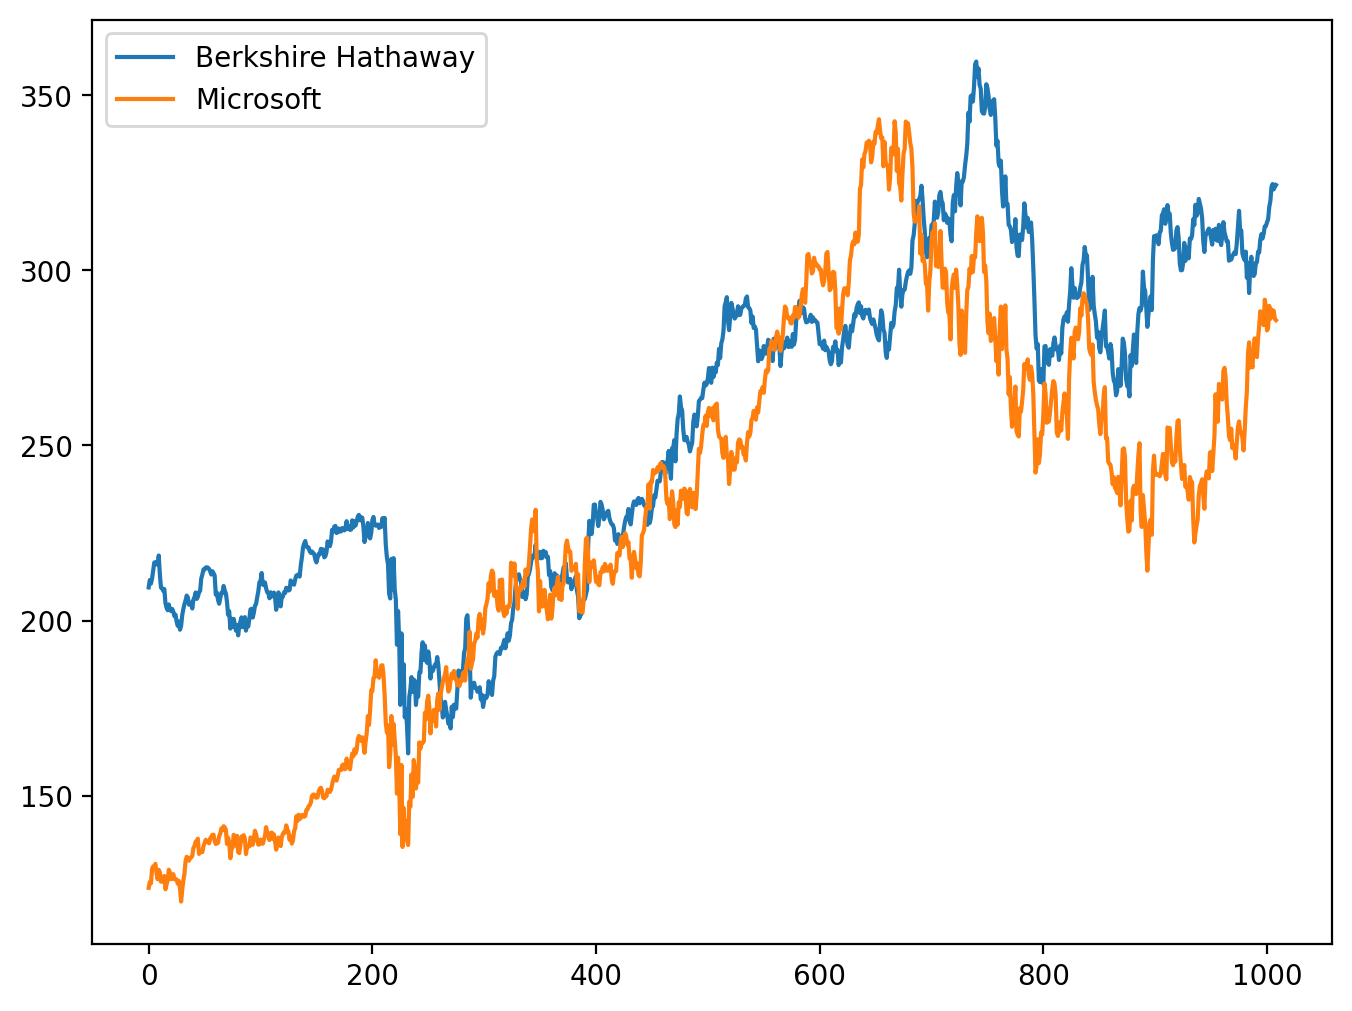

In [130]:
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8,6), dpi=200)
plt.plot(bskb_df['Adj Close'], label="Berkshire Hathaway")
plt.plot(msft_df['Adj Close'], label = "Microsoft")
plt.legend()

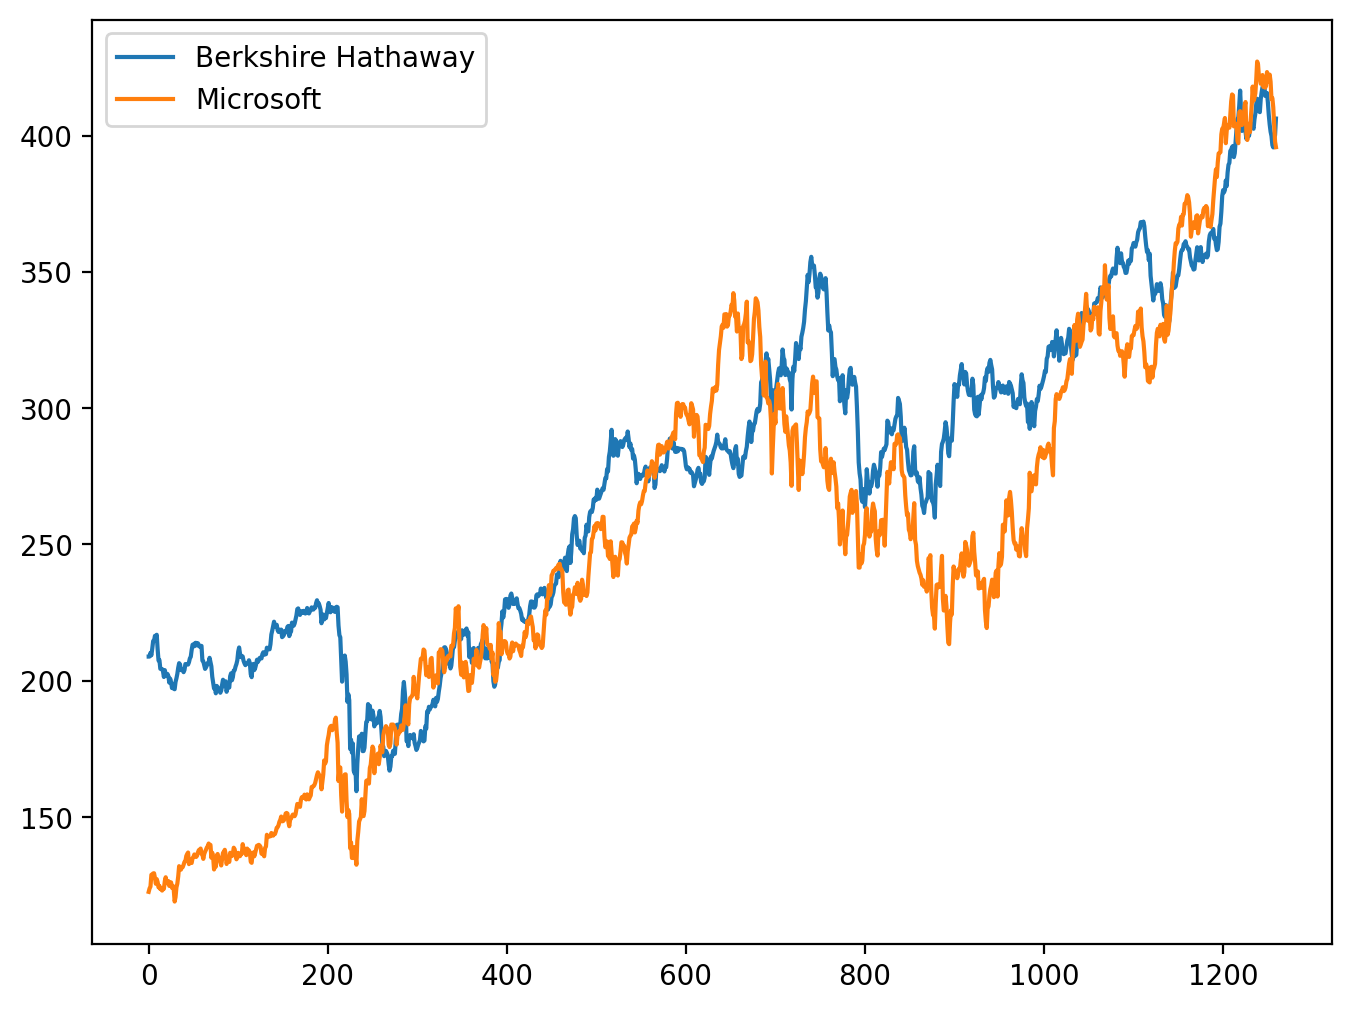

In [108]:
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8,6), dpi=200)
plt.plot(bskb_df['Low'], label="Berkshire Hathaway")
plt.plot(msft_df['Low'], label = "Microsoft")
plt.legend()

In [110]:
msft_df.drop(columns=['Volume'], inplace=True)

,Date,Open,High,Low,Close,Adj Close
0,2019-04-22,122.620003,124.000000,122.570000,123.760002,117.806198
1,2019-04-23,124.099998,125.580002,123.830002,125.440002,119.405373
2,2019-04-24,125.790001,125.849998,124.519997,125.010002,118.996063
3,2019-04-25,130.059998,131.369995,128.830002,129.149994,122.936890
4,2019-04-26,129.699997,130.520004,129.020004,129.889999,123.641312
...,...,...,...,...,...,...
1255,2024-04-16,414.570007,418.399994,413.730011,414.579987,414.579987
1256,2024-04-17,417.250000,418.880005,410.329987,411.839996,411.839996
1257,2024-04-18,410.630005,411.890015,403.950012,404.269989,404.269989
1258,2024-04-19,404.029999,405.480011,397.769989,399.119995,399.119995


In [115]:
msft_df['Daily Returns'] = msft_df['Adj Close'].pct_change(1)


,Date,Open,High,Low,Close,Adj Close,Daily Return,Daily Returns
0,2019-04-22,122.620003,124.000000,122.570000,123.760002,117.806198,NaN,NaN
1,2019-04-23,124.099998,125.580002,123.830002,125.440002,119.405373,0.013575,0.013575
2,2019-04-24,125.790001,125.849998,124.519997,125.010002,118.996063,-0.003428,-0.003428
3,2019-04-25,130.059998,131.369995,128.830002,129.149994,122.936890,0.033117,0.033117
4,2019-04-26,129.699997,130.520004,129.020004,129.889999,123.641312,0.005730,0.005730
...,...,...,...,...,...,...,...,...
1255,2024-04-16,414.570007,418.399994,413.730011,414.579987,414.579987,0.002272,0.002272
1256,2024-04-17,417.250000,418.880005,410.329987,411.839996,411.839996,-0.006609,-0.006609
1257,2024-04-18,410.630005,411.890015,403.950012,404.269989,404.269989,-0.018381,-0.018381
1258,2024-04-19,404.029999,405.480011,397.769989,399.119995,399.119995,-0.012739,-0.012739


In [119]:
msft_df.drop(columns=['Daily Return'], inplace=True)

In [120]:
msft_df['10 Day Returns'] = msft_df['Adj Close'].pct_change(10)
msft_df

,Date,Open,High,Low,Close,Adj Close,Daily Returns,10 Day Returns
0,2019-04-22,122.620003,124.000000,122.570000,123.760002,117.806198,NaN,NaN
1,2019-04-23,124.099998,125.580002,123.830002,125.440002,119.405373,0.013575,NaN
2,2019-04-24,125.790001,125.849998,124.519997,125.010002,118.996063,-0.003428,NaN
3,2019-04-25,130.059998,131.369995,128.830002,129.149994,122.936890,0.033117,NaN
4,2019-04-26,129.699997,130.520004,129.020004,129.889999,123.641312,0.005730,NaN
...,...,...,...,...,...,...,...,...
1255,2024-04-16,414.570007,418.399994,413.730011,414.579987,414.579987,0.002272,-0.016278
1256,2024-04-17,417.250000,418.880005,410.329987,411.839996,411.839996,-0.006609,-0.020478
1257,2024-04-18,410.630005,411.890015,403.950012,404.269989,404.269989,-0.018381,-0.032569
1258,2024-04-19,404.029999,405.480011,397.769989,399.119995,399.119995,-0.012739,-0.062042


In [124]:
import pandas as pd

# Assuming df is your DataFrame and 'E' is your column with data
# Load your data
# df = pd.read_csv('your_data.csv')

# Define the window size
window_size = 30

# Calculate rolling mean and standard deviation, shift for alignment
rolling_mean = msft_df['10 Day Returns'].rolling(window=window_size).mean().shift(-window_size + 1)
rolling_std = msft_df['10 Day Returns'].rolling(window=window_size).std().shift(-window_size + 1)

# Standardize the data
msft_df['Z10'] = (msft_df['10 Day Returns'] - rolling_mean) / rolling_std

# Optionally, remove NaN values which will appear at the end of the DataFrame because of shifting
# df.dropna(subset=['Standardized_E'], inplace=True)
msft_df.head(20)
# Display the results
# print(df[['E', 'Standardized_E']])


,Date,Open,High,Low,Close,Adj Close,Daily Returns,10 Day Returns,Z10
0,2019-04-22,122.620003,124.000000,122.570000,123.760002,117.806198,NaN,NaN,NaN
1,2019-04-23,124.099998,125.580002,123.830002,125.440002,119.405373,0.013575,NaN,NaN
2,2019-04-24,125.790001,125.849998,124.519997,125.010002,118.996063,-0.003428,NaN,NaN
3,2019-04-25,130.059998,131.369995,128.830002,129.149994,122.936890,0.033117,NaN,NaN
4,2019-04-26,129.699997,130.520004,129.020004,129.889999,123.641312,0.005730,NaN,NaN
5,2019-04-29,129.899994,130.179993,129.350006,129.770004,123.527092,-0.000924,NaN,NaN
6,2019-04-30,129.809998,130.699997,129.389999,130.600006,124.317146,0.006396,NaN,NaN
7,2019-05-01,130.529999,130.649994,127.699997,127.879997,121.728012,-0.020827,NaN,NaN
8,2019-05-02,127.980003,128.000000,125.519997,126.209999,120.138329,-0.013059,NaN,NaN
9,2019-05-03,127.360001,129.429993,127.250000,128.899994,122.698921,0.021314,NaN,NaN


In [125]:
msft_df.drop(columns=['Z10'], inplace=True)
msft_df

,Date,Open,High,Low,Close,Adj Close,Daily Returns,10 Day Returns
0,2019-04-22,122.620003,124.000000,122.570000,123.760002,117.806198,NaN,NaN
1,2019-04-23,124.099998,125.580002,123.830002,125.440002,119.405373,0.013575,NaN
2,2019-04-24,125.790001,125.849998,124.519997,125.010002,118.996063,-0.003428,NaN
3,2019-04-25,130.059998,131.369995,128.830002,129.149994,122.936890,0.033117,NaN
4,2019-04-26,129.699997,130.520004,129.020004,129.889999,123.641312,0.005730,NaN
...,...,...,...,...,...,...,...,...
1255,2024-04-16,414.570007,418.399994,413.730011,414.579987,414.579987,0.002272,-0.016278
1256,2024-04-17,417.250000,418.880005,410.329987,411.839996,411.839996,-0.006609,-0.020478
1257,2024-04-18,410.630005,411.890015,403.950012,404.269989,404.269989,-0.018381,-0.032569
1258,2024-04-19,404.029999,405.480011,397.769989,399.119995,399.119995,-0.012739,-0.062042
